In [1]:
from src.data.eeg_measurement import EegMeasurement
from src.data.eeg_attention_pytorch_dataset import EegAttentionDataset
from src.evaluation.eval_vanilla_ridge import RidgeEvaluator

import numpy as np
import git
import os
import pandas
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy

from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

import git
import src.data.utils as data_utils
import src.evaluation.utils as eval_utils
import pickle

import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

from os.path import join
from pandas import read_csv

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]

fig_path = os.path.join(base_dir, 'reports', 'figures', 'learnable_thresholding')
plt.rcParams["font.family"] = "Times New Roman"

### Load data

In [4]:
#load data
lin_path_thres = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_svm_values/lin_acc_thres_list.npy')
lin_path_svm = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_svm_values/lin_acc_svm_list.npy')

cnn_pre_path_thres = os.path.join(base_dir, 'reports/metrics/cnn/152/windowed_svm_valued/cnn_acc_thres_list.npy')
cnn_pre_path_svm = os.path.join(base_dir, 'reports/metrics/cnn/152/windowed_svm_valued/cnn_acc_svm_list.npy')

cnn_subj_pre_path_thres = os.path.join(base_dir, 'reports/metrics/cnn/153/windowed_svm_valued/cnn_acc_thres_list.npy')
cnn_subj_pre_path_svm = os.path.join(base_dir, 'reports/metrics/cnn/153/windowed_svm_valued/cnn_acc_svm_list.npy')

#shape of the arrays: (n_windows, n_subjects)
lin_acc_thres_values = np.load(lin_path_thres)
lin_acc_svm_values = np.load(lin_path_svm)

cnn_acc_thres_values = np.load(cnn_pre_path_thres)
cnn_acc_svm_values = np.load(cnn_pre_path_svm)

cnn_acc_thres_values_subj = np.load(cnn_subj_pre_path_thres)
cnn_acc_svm_values_subj = np.load(cnn_subj_pre_path_svm)

In [5]:
#get mean and s.e.m. over subjects
lin_acc_thres_mean, lin_acc_thres_sem = np.mean(lin_acc_thres_values, axis=1), scipy.stats.sem(lin_acc_thres_values, axis=1)
lin_acc_svm_mean, lin_acc_svm_sem = np.mean(lin_acc_svm_values, axis=1), scipy.stats.sem(lin_acc_svm_values, axis=1)

cnn_acc_thres_mean, cnn_acc_thres_sem = np.mean(cnn_acc_thres_values, axis=1), scipy.stats.sem(cnn_acc_thres_values, axis=1)
cnn_acc_svm_mean, cnn_acc_svm_sem = np.mean(cnn_acc_svm_values, axis=1), scipy.stats.sem(cnn_acc_svm_values, axis=1)

cnn_acc_thres_mean_subj, cnn_acc_thres_sem_subj = np.mean(cnn_acc_thres_values_subj, axis=1), scipy.stats.sem(cnn_acc_thres_values_subj, axis=1)
cnn_acc_svm_mean_subj, cnn_acc_svm_sem_subj = np.mean(cnn_acc_svm_values_subj, axis=1), scipy.stats.sem(cnn_acc_svm_values_subj, axis=1)

### Fitting sqrt function to the data

In [6]:
def parametrized_sqrt(x, a, b, c, d):
    return a * np.sqrt(b * x - c) + d

In [7]:
def ci_95_acc(n_window):
    p = 1.0
    #successes
    k = int(np.ceil(n_window / 2))
    while p > 0.05:
        res = scipy.stats.binomtest(k, n_window, p=0.5, alternative='greater')
        p = res.pvalue
        k = k + 1
    return k / n_window

In [8]:
#getting number of evaluated windows
acc_window_sizes = np.array([60,45,30,20,10,5,2,1])

n_trial = 12
n_subjects = 23
n_windows = np.floor(120 / np.array(acc_window_sizes)) * n_trial * n_subjects
#cast n_windows to int
n_windows = n_windows.astype(int)
ci_95 = np.array([ci_95_acc(n) for n in n_windows])

params_ci, pcov_ci = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, np.array(ci_95), p0=[1, 1, 0.1, 0.5], method='trf')
sqrt_fit_ci = parametrized_sqrt(np.array(acc_window_sizes), params_ci[0], params_ci[1], params_ci[2], params_ci[3])

/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_9133/3014285489.py:2: RuntimeWarning: invalid value encountered in sqrt
  return a * np.sqrt(b * x - c) + d


In [9]:
#fitting the sqrt function
params_lin_thres, _ = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, lin_acc_thres_mean, p0=[1, 1.1, 0.1, 0.5], method='trf')
params_cnn_thres_subj, _ = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, cnn_acc_thres_mean_subj, p0=[1.1, 1.1, 0.1, 0.5], method='trf')
params_cnn_thres_pre, _ = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, cnn_acc_thres_mean, p0=[1.0, 1.0, 0.1, 0.4], method='trf')

sqrt_fit_lin_thres = parametrized_sqrt(acc_window_sizes, *params_lin_thres)
sqrt_fit_cnn_thres_subj = parametrized_sqrt(acc_window_sizes, *params_cnn_thres_subj)
sqrt_fit_cnn_thres_pre = parametrized_sqrt(acc_window_sizes, *params_cnn_thres_pre)

params_lin_svm, _ = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, lin_acc_svm_mean, p0=[1, 1, 0.1, 0.5], method='trf')

params_cnn_svm_subj, _ = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, cnn_acc_svm_mean_subj, p0=[1.1, 1.1, 0.1, 0.5], method='trf')
params_cnn_svm_pre, _ = scipy.optimize.curve_fit(parametrized_sqrt, acc_window_sizes, cnn_acc_svm_mean, p0=[1.1, 1.1, 0.1, 0.5], method='trf')

sqrt_fit_lin_svm = parametrized_sqrt(acc_window_sizes, *params_lin_svm)
sqrt_fit_cnn_svm_subj = parametrized_sqrt(acc_window_sizes, *params_cnn_svm_subj)
sqrt_fit_cnn_svm_pre = parametrized_sqrt(acc_window_sizes, *params_cnn_svm_pre)

/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_9133/3014285489.py:2: RuntimeWarning: invalid value encountered in sqrt
  return a * np.sqrt(b * x - c) + d


In [10]:
marker_size = 5
cap_size = 2

label_fontsize = 12
tick_fontsize = 10


linestyle_diagonal = '-.'
linestyle_svm = '-'
linewidth = 1.5

axis_linewidth = 1.0

y_ticks = [0, 0.2, 0.4]

p-values for different window sizes on population level comparing ridge and cnn (pretrained)
window size: 60s, p-value: 0.04935852124289169
window size: 45s, p-value: 0.009824215023436784
window size: 30s, p-value: 0.002087825063966485
window size: 20s, p-value: 0.029614339315187373
window size: 10s, p-value: 0.009568625578534119
window size: 5s, p-value: 0.0086957137025509
window size: 2s, p-value: 0.010132816881498927
window size: 1s, p-value: 0.02428191167527831
number of windows with significanct differeces: 8


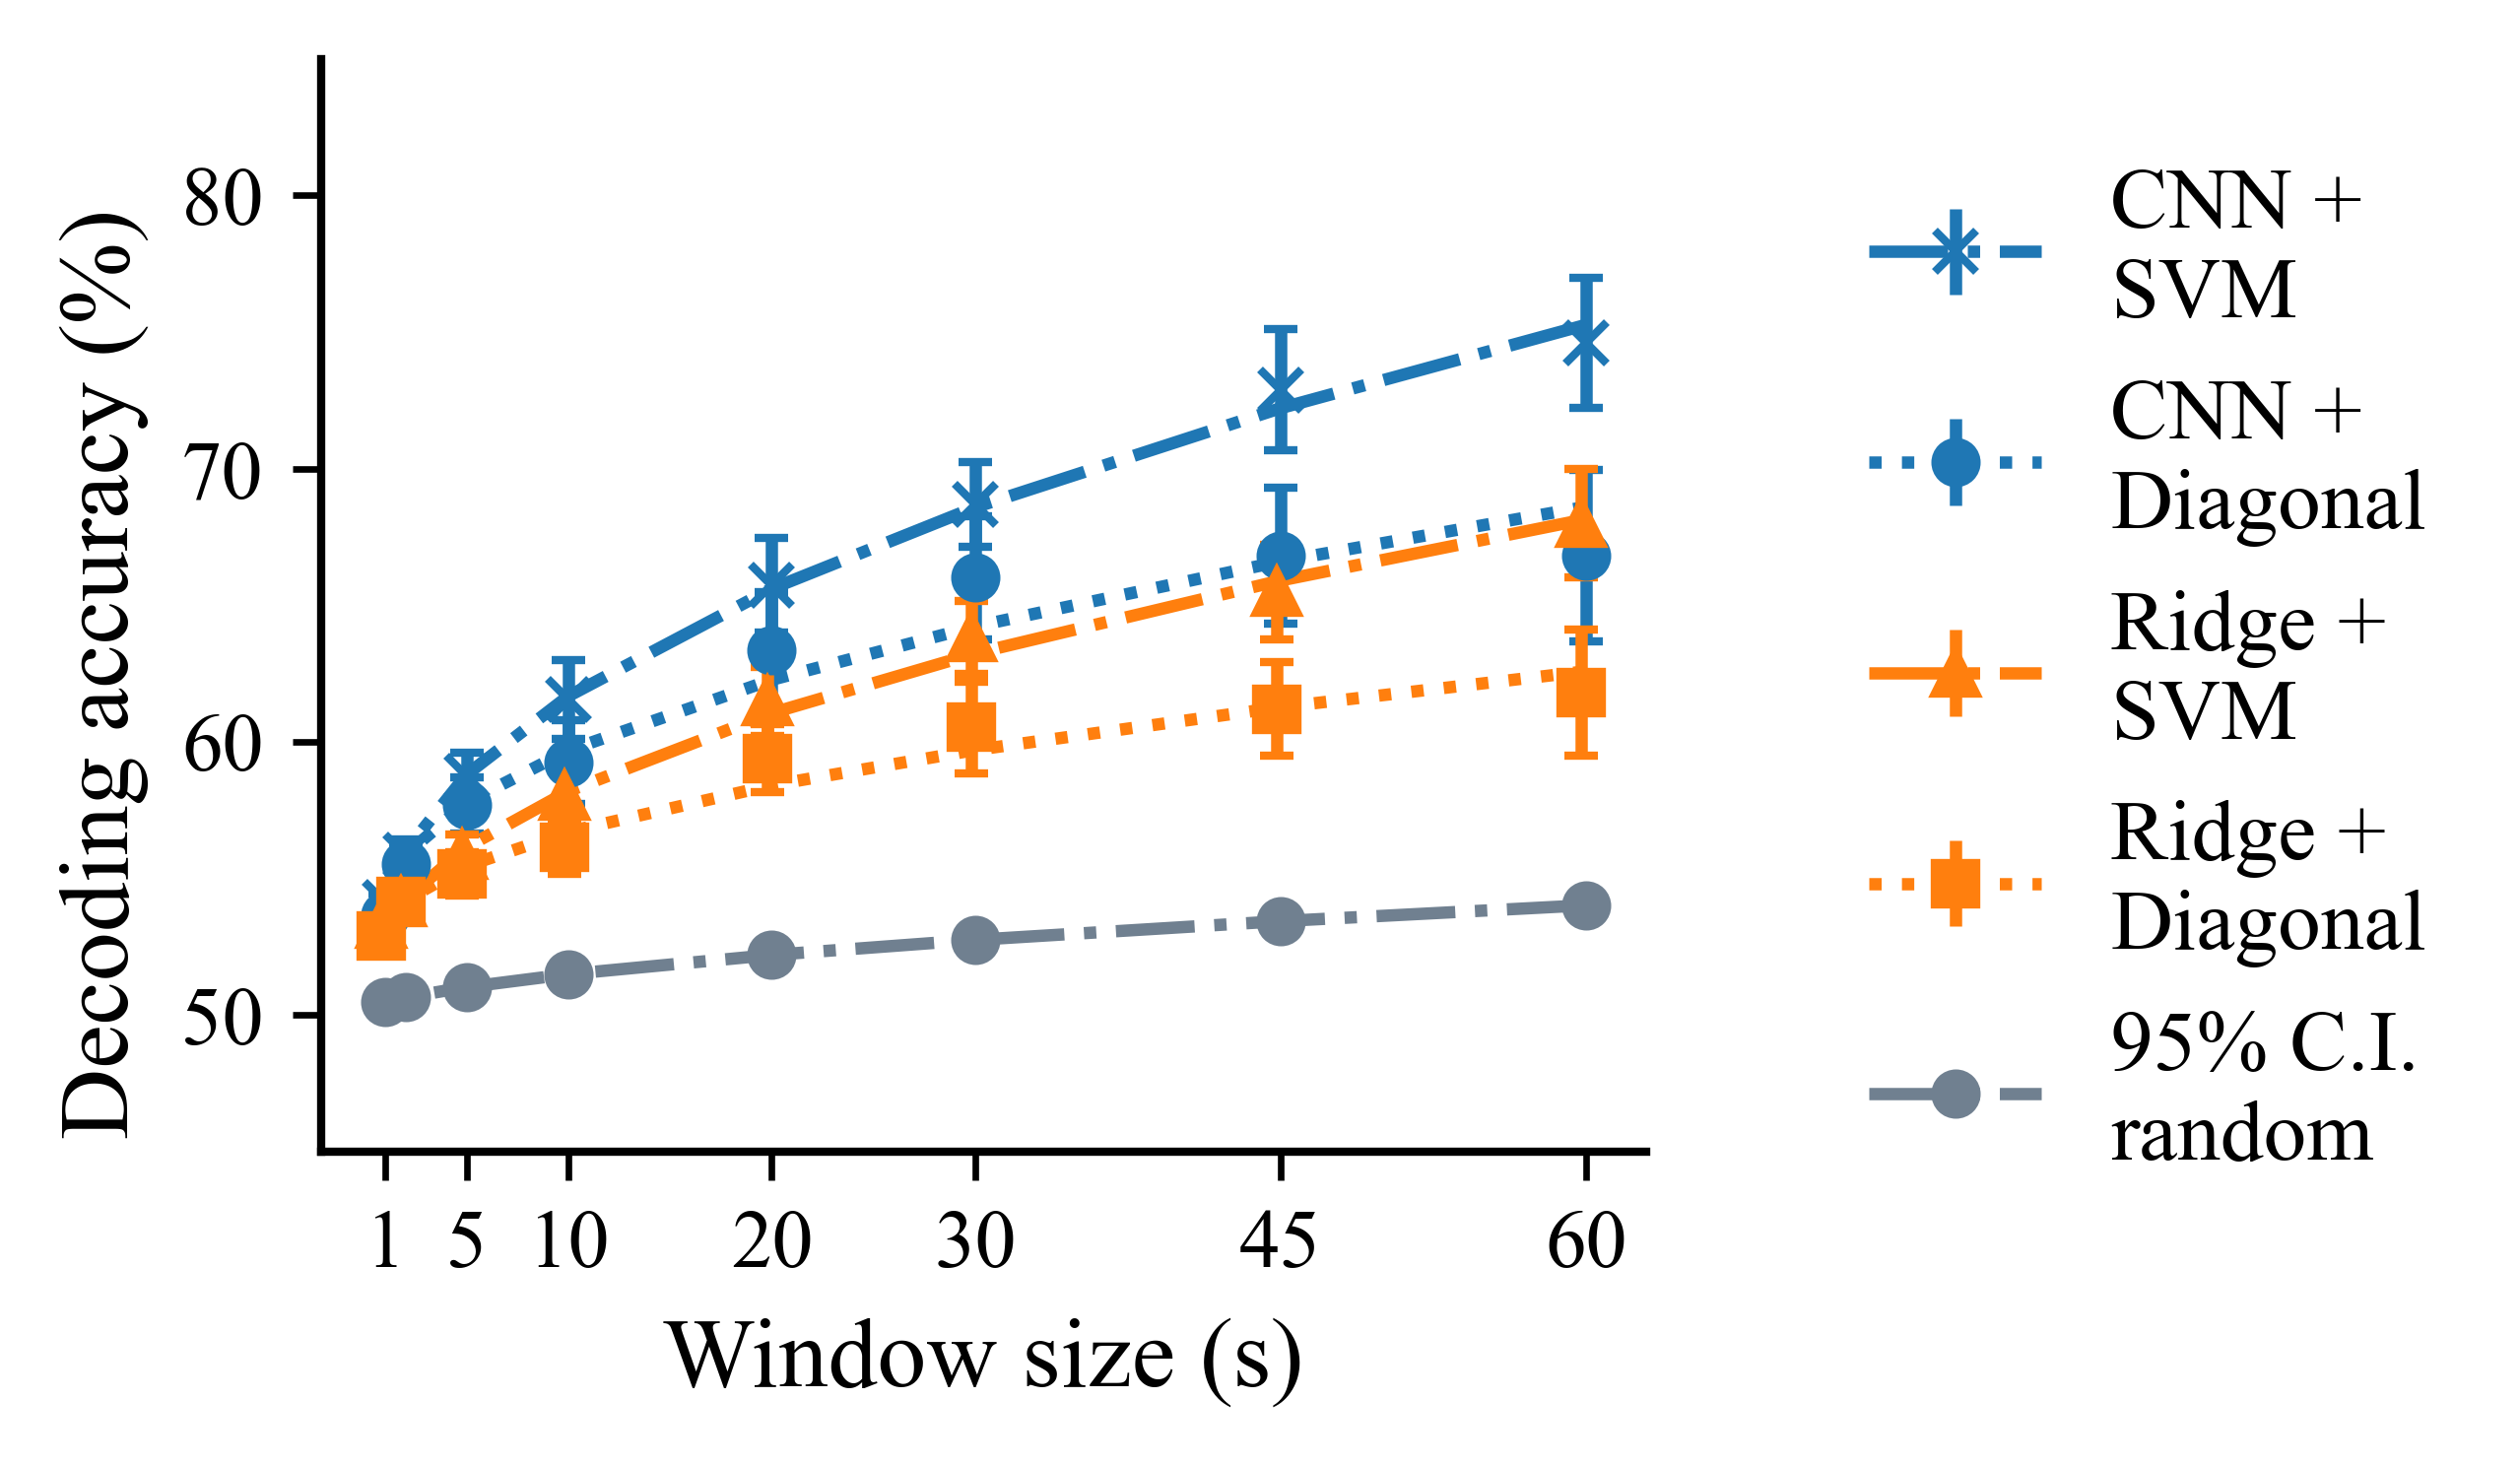

In [12]:
acc_window_sizes = np.array(acc_window_sizes)
fig = plt.figure(figsize=(3.5, 2.1), dpi=600)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 0.1])
ax, ax1  = spec.subplots()

#hack how to get legend with errorbar scatters + interpoloations
#taken from https://stackoverflow.com/questions/60522042/matplotlib-how-to-combine-scatter-and-line-plot-to-one-legend-entry
prop = ax._get_lines.prop_cycler
color = next(prop)['color']

thres_sig = eval_utils.check_significances_on_windows(lin_acc_thres_values, cnn_acc_thres_values)

ax.errorbar(acc_window_sizes, cnn_acc_svm_mean, yerr=cnn_acc_svm_sem, fmt = 'x', c=c_cnn, capsize=cap_size, markersize = marker_size)
ax.plot(acc_window_sizes, sqrt_fit_cnn_svm_pre, c=c_cnn, linestyle='-.', linewidth=linewidth, alpha = 1)
#just to get legend entry
ax.errorbar([],[], yerr=[], fmt = '-.x', c = c_cnn, label = 'CNN +\nSVM', capsize=cap_size, markersize = marker_size, linewidth = linewidth)
color = next(prop)['color']

ax.errorbar(acc_window_sizes, cnn_acc_thres_mean, yerr=cnn_acc_thres_sem, fmt = 'o', c=c_cnn, capsize=cap_size, markersize = marker_size, alpha = 1)
ax.plot(acc_window_sizes, sqrt_fit_cnn_thres_pre, c=c_cnn, linestyle=':', linewidth=linewidth, alpha = 1)
ax.errorbar([],[], yerr=[], fmt = ':o', c = c_cnn, label = 'CNN +\nDiagonal', capsize=cap_size, markersize = marker_size, linewidth = linewidth, alpha = 1)
color = next(prop)['color']

ax.errorbar(acc_window_sizes-0.2, lin_acc_svm_mean, yerr=lin_acc_svm_sem,  fmt = '^', c=c_ridge, capsize=cap_size, markersize = marker_size)
ax.plot(acc_window_sizes, sqrt_fit_lin_svm, c=c_ridge, linestyle='-.', linewidth=linewidth)
ax.errorbar([],[], yerr=[], fmt = '-.^', c = c_ridge, label = 'Ridge +\nSVM', capsize=cap_size, markersize = marker_size, linewidth = linewidth)
color = next(prop)['color']

ax.errorbar(acc_window_sizes-0.2, lin_acc_thres_mean, yerr=lin_acc_thres_sem,  fmt = 's',  c=c_ridge, capsize=cap_size, markersize = marker_size, alpha = 1)
ax.plot(acc_window_sizes, sqrt_fit_lin_thres, c=c_ridge, linestyle=':', linewidth=linewidth, alpha = 1)
ax.errorbar([],[], yerr=[], fmt = ':s', c = c_ridge, label = 'Ridge +\nDiagonal', capsize=cap_size, markersize = marker_size, linewidth = linewidth, alpha = 1)
color = next(prop)['color']

ax.plot(acc_window_sizes, sqrt_fit_ci, 'o', c='slategrey', linestyle='-.', linewidth=linewidth, markersize=marker_size, label = '95% C.I.\nrandom')

ax.set_ylim([0.45, 0.80])
ax.set_xlabel('Window size (s)', fontsize=label_fontsize)
ax.set_ylabel('Decoding accuracy (%)', fontsize=label_fontsize)

handles, labels = ax.get_legend_handles_labels()
#bring into correct order
ordered_handels = [handles[i] for i in range(1, len(handles))]
ordered_handels.append(handles[0])
handles = ordered_handels

ordered_labels = [labels[i] for i in range(1,len(labels))]
ordered_labels.append(labels[0])
labels = ordered_labels

# sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.set_xticks([1,5,10,20,30,45,60])
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0, symbol=None))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(0.45, 0.85)
ax.spines['left'].set_linewidth(axis_linewidth)
ax.spines['bottom'].set_linewidth(axis_linewidth)

ax1.legend(handles, labels, loc = 'center left', fontsize=tick_fontsize+0.5, ncols=1, frameon=False)
ax1.axis('off')

os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'decoding_accuracy_as_function_of_window_size_all_models.pdf'), bbox_inches='tight', dpi=600)
fig.savefig(os.path.join(fig_path, 'decoding_accuracy_as_function_of_window_size_all_models.png'), bbox_inches='tight', dpi=600)
fig.savefig(os.path.join(fig_path, 'decoding_accuracy_as_function_of_window_size_all_models.svg'), bbox_inches='tight', dpi=600)